# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys
import multiprocessing

# multiprocessing.set_start_method('spawn')
from MyUtils import clean_folder, read_files, shuffle_docs
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
initial_train_size = len(train_labels)
train_texts, train_labels = shuffle_docs(train_texts, train_labels)
validation_size = len(train_texts) - initial_train_size
class_size = int(initial_train_size / len(set(train_labels)))
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim(lang= language[index])
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels, tf= tf)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  819
process_doc, done!
word_set, ready!
fit_transform_texts is done!
doc count to process:  468
Reading problem 1, done!


# Data Extraction for Neural Net



In [3]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_ngrams = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data_ngrams = max_abs_scaler.transform(n_gram_test_data)
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_words = max_abs_scaler.fit_transform(w2d.get_texts_vectorized_and_normalized(train_tokenized_indexed)[:, 1:])
scaled_test_data_words = max_abs_scaler.transform(w2d.get_texts_vectorized_and_normalized(test_tokenized_indexed)[:, 1:])
print("Done!")

Done!


In [4]:
print(scaled_train_data_words.shape)
print(scaled_test_data_words.shape)
print(len(w2d.word_index))

(819, 7623)
(468, 7623)
7623


In [8]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

from numpy import argmax
from sklearn.metrics import accuracy_score
from keras import layers, Input, callbacks
from keras.models import Sequential, Model, load_model
from keras import optimizers, regularizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

callbacks_list_neu = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_ngrams = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_ngrams.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_neu_words = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_neu_words.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

callbacks_list_convnet = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=35,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model_convnet.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=10,
    )
]

callbacks_list_stacked = [
    callbacks.ModelCheckpoint(
        filepath='my_model_stacked.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

# X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_words, X_scaled_val_data_words, _, _ = train_test_split(scaled_train_data_words, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)
# X_scaled_train_data_ngrams, X_scaled_val_data_ngrams, _, _ = train_test_split(scaled_train_data_ngrams, train_labels,
#                                                   test_size=validation_size,
#                                                   stratify=train_labels)

y_train, y_val = train_labels[:initial_train_size], train_labels[initial_train_size:]
X_train, X_val = train_data[:initial_train_size], train_data[initial_train_size:]
X_scaled_train_data_words, X_scaled_val_data_words = scaled_train_data_words[:initial_train_size], scaled_train_data_words[initial_train_size:]
X_scaled_train_data_ngrams, X_scaled_val_data_ngrams = scaled_train_data_ngrams[:initial_train_size], scaled_train_data_ngrams[initial_train_size:]

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# y_test = to_categorical(test_labels)
# print(X_train.shape)

print(y_train.shape)


(63, 9)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                132896    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)  

63/63 [==============================] - 0s 3ms/step - loss: 3.7442 - acc: 0.6190 - val_loss: 3.3861 - val_acc: 0.9669
Epoch 46/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.5890 - acc: 0.6667 - val_loss: 3.3495 - val_acc: 0.9894
Epoch 47/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.6476 - acc: 0.6667 - val_loss: 3.3088 - val_acc: 0.9974
Epoch 48/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.6186 - acc: 0.6032 - val_loss: 3.2670 - val_acc: 0.9974
Epoch 49/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.5607 - acc: 0.6984 - val_loss: 3.2230 - val_acc: 0.9947
Epoch 50/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.4575 - acc: 0.6984 - val_loss: 3.1798 - val_acc: 0.9947
Epoch 51/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.4683 - acc: 0.6667 - val_loss: 3.1428 - val_acc: 0.9987
Epoch 52/1500
63/63 [==============================] - 0s 3ms/step - loss: 3.5125 -

63/63 [==============================] - 0s 3ms/step - loss: 2.2726 - acc: 0.8571 - val_loss: 1.9351 - val_acc: 1.0000
Epoch 107/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.3200 - acc: 0.9048 - val_loss: 1.9250 - val_acc: 1.0000
Epoch 108/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.3136 - acc: 0.9048 - val_loss: 1.9174 - val_acc: 1.0000
Epoch 109/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.3193 - acc: 0.9048 - val_loss: 1.9076 - val_acc: 1.0000
Epoch 110/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.2024 - acc: 0.9524 - val_loss: 1.8958 - val_acc: 1.0000
Epoch 111/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.1795 - acc: 0.9048 - val_loss: 1.8837 - val_acc: 1.0000
Epoch 112/1500
63/63 [==============================] - 0s 3ms/step - loss: 2.2016 - acc: 0.9048 - val_loss: 1.8732 - val_acc: 1.0000
Epoch 113/1500
63/63 [==============================] - 0s 3ms/step - loss: 2

63/63 [==============================] - 0s 3ms/step - loss: 1.7495 - acc: 0.9365 - val_loss: 1.4805 - val_acc: 1.0000
Epoch 168/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.8012 - acc: 0.9365 - val_loss: 1.4776 - val_acc: 1.0000
Epoch 169/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.7245 - acc: 0.9683 - val_loss: 1.4742 - val_acc: 1.0000
Epoch 170/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.7636 - acc: 0.8889 - val_loss: 1.4693 - val_acc: 1.0000
Epoch 171/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.6470 - acc: 0.9841 - val_loss: 1.4624 - val_acc: 1.0000
Epoch 172/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.7266 - acc: 0.9365 - val_loss: 1.4570 - val_acc: 1.0000
Epoch 173/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.7299 - acc: 0.9524 - val_loss: 1.4525 - val_acc: 1.0000
Epoch 174/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

Epoch 228/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4338 - acc: 0.9841 - val_loss: 1.2373 - val_acc: 1.0000
Epoch 229/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4947 - acc: 0.9365 - val_loss: 1.2332 - val_acc: 1.0000
Epoch 230/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4864 - acc: 0.9206 - val_loss: 1.2309 - val_acc: 1.0000
Epoch 231/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4725 - acc: 0.9524 - val_loss: 1.2277 - val_acc: 1.0000
Epoch 232/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4211 - acc: 0.9683 - val_loss: 1.2231 - val_acc: 1.0000
Epoch 233/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4427 - acc: 0.9206 - val_loss: 1.2210 - val_acc: 1.0000
Epoch 234/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.3924 - acc: 0.9683 - val_loss: 1.2177 - val_acc: 1.0000
Epoch 235/1500
63/63 [==============================] - 0s 3ms

63/63 [==============================] - 0s 3ms/step - loss: 1.2191 - acc: 0.9683 - val_loss: 1.0880 - val_acc: 1.0000
Epoch 290/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.2396 - acc: 0.9683 - val_loss: 1.0850 - val_acc: 1.0000
Epoch 291/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.2858 - acc: 0.9206 - val_loss: 1.0836 - val_acc: 1.0000
Epoch 292/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.3046 - acc: 0.9683 - val_loss: 1.0824 - val_acc: 1.0000
Epoch 293/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.3450 - acc: 0.9206 - val_loss: 1.0817 - val_acc: 1.0000
Epoch 294/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.4149 - acc: 0.9206 - val_loss: 1.0844 - val_acc: 1.0000
Epoch 295/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.2203 - acc: 1.0000 - val_loss: 1.0824 - val_acc: 1.0000
Epoch 296/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

63/63 [==============================] - 0s 3ms/step - loss: 1.1813 - acc: 0.9524 - val_loss: 0.9993 - val_acc: 1.0000
Epoch 351/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.1293 - acc: 0.9841 - val_loss: 0.9958 - val_acc: 1.0000
Epoch 352/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.1473 - acc: 0.9683 - val_loss: 0.9930 - val_acc: 1.0000
Epoch 353/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.2050 - acc: 0.9365 - val_loss: 0.9939 - val_acc: 1.0000
Epoch 354/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.2008 - acc: 0.9365 - val_loss: 0.9929 - val_acc: 1.0000
Epoch 355/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.1382 - acc: 0.9841 - val_loss: 0.9907 - val_acc: 1.0000
Epoch 356/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.1911 - acc: 0.9683 - val_loss: 0.9875 - val_acc: 1.0000
Epoch 357/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

63/63 [==============================] - 0s 3ms/step - loss: 1.0579 - acc: 1.0000 - val_loss: 0.9310 - val_acc: 1.0000
Epoch 412/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.1070 - acc: 0.9841 - val_loss: 0.9306 - val_acc: 1.0000
Epoch 413/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0553 - acc: 0.9841 - val_loss: 0.9300 - val_acc: 1.0000
Epoch 414/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0825 - acc: 0.9365 - val_loss: 0.9287 - val_acc: 1.0000
Epoch 415/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0440 - acc: 0.9841 - val_loss: 0.9278 - val_acc: 1.0000
Epoch 416/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0825 - acc: 0.9524 - val_loss: 0.9259 - val_acc: 1.0000
Epoch 417/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0864 - acc: 0.9524 - val_loss: 0.9236 - val_acc: 1.0000
Epoch 418/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

63/63 [==============================] - 0s 3ms/step - loss: 0.9848 - acc: 0.9683 - val_loss: 0.8879 - val_acc: 1.0000
Epoch 473/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9573 - acc: 1.0000 - val_loss: 0.8840 - val_acc: 1.0000
Epoch 474/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0025 - acc: 0.9683 - val_loss: 0.8787 - val_acc: 1.0000
Epoch 475/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0105 - acc: 0.9841 - val_loss: 0.8769 - val_acc: 1.0000
Epoch 476/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0126 - acc: 0.9841 - val_loss: 0.8773 - val_acc: 1.0000
Epoch 477/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9853 - acc: 1.0000 - val_loss: 0.8757 - val_acc: 1.0000
Epoch 478/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0215 - acc: 0.9841 - val_loss: 0.8733 - val_acc: 1.0000
Epoch 479/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

63/63 [==============================] - 0s 3ms/step - loss: 0.9876 - acc: 0.9683 - val_loss: 0.8477 - val_acc: 1.0000
Epoch 534/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9882 - acc: 0.9841 - val_loss: 0.8477 - val_acc: 1.0000
Epoch 535/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9517 - acc: 1.0000 - val_loss: 0.8441 - val_acc: 1.0000
Epoch 536/1500
63/63 [==============================] - 0s 3ms/step - loss: 1.0227 - acc: 0.9683 - val_loss: 0.8422 - val_acc: 1.0000
Epoch 537/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9234 - acc: 1.0000 - val_loss: 0.8415 - val_acc: 1.0000
Epoch 538/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9520 - acc: 1.0000 - val_loss: 0.8390 - val_acc: 1.0000
Epoch 539/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9871 - acc: 0.9841 - val_loss: 0.8379 - val_acc: 1.0000
Epoch 540/1500
63/63 [==============================] - 0s 3ms/step - loss: 1

63/63 [==============================] - 0s 3ms/step - loss: 0.9178 - acc: 0.9683 - val_loss: 0.8115 - val_acc: 1.0000
Epoch 595/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9234 - acc: 0.9683 - val_loss: 0.8101 - val_acc: 1.0000
Epoch 596/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9442 - acc: 0.9365 - val_loss: 0.8075 - val_acc: 1.0000
Epoch 597/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9159 - acc: 0.9841 - val_loss: 0.8057 - val_acc: 1.0000
Epoch 598/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9487 - acc: 0.9841 - val_loss: 0.8076 - val_acc: 1.0000
Epoch 599/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9771 - acc: 0.9683 - val_loss: 0.8077 - val_acc: 1.0000
Epoch 600/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9339 - acc: 0.9683 - val_loss: 0.8059 - val_acc: 1.0000
Epoch 601/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.8934 - acc: 1.0000 - val_loss: 0.7748 - val_acc: 1.0000
Epoch 656/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8922 - acc: 0.9683 - val_loss: 0.7744 - val_acc: 1.0000
Epoch 657/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9036 - acc: 1.0000 - val_loss: 0.7752 - val_acc: 1.0000
Epoch 658/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8361 - acc: 1.0000 - val_loss: 0.7733 - val_acc: 1.0000
Epoch 659/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8622 - acc: 1.0000 - val_loss: 0.7700 - val_acc: 1.0000
Epoch 660/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9326 - acc: 0.9365 - val_loss: 0.7697 - val_acc: 1.0000
Epoch 661/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8990 - acc: 0.9524 - val_loss: 0.7750 - val_acc: 1.0000
Epoch 662/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.8669 - acc: 0.9841 - val_loss: 0.7536 - val_acc: 1.0000
Epoch 717/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8290 - acc: 1.0000 - val_loss: 0.7517 - val_acc: 1.0000
Epoch 718/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8392 - acc: 0.9841 - val_loss: 0.7491 - val_acc: 1.0000
Epoch 719/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9086 - acc: 0.9524 - val_loss: 0.7494 - val_acc: 1.0000
Epoch 720/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8620 - acc: 0.9841 - val_loss: 0.7515 - val_acc: 1.0000
Epoch 721/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9116 - acc: 0.9524 - val_loss: 0.7513 - val_acc: 1.0000
Epoch 722/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8636 - acc: 0.9683 - val_loss: 0.7546 - val_acc: 1.0000
Epoch 723/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.8579 - acc: 0.9841 - val_loss: 0.7199 - val_acc: 1.0000
Epoch 778/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.9124 - acc: 0.9524 - val_loss: 0.7232 - val_acc: 1.0000
Epoch 779/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8096 - acc: 0.9841 - val_loss: 0.7239 - val_acc: 1.0000
Epoch 780/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8198 - acc: 0.9683 - val_loss: 0.7222 - val_acc: 1.0000
Epoch 781/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8136 - acc: 1.0000 - val_loss: 0.7206 - val_acc: 1.0000
Epoch 782/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8548 - acc: 0.9524 - val_loss: 0.7193 - val_acc: 1.0000
Epoch 783/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7974 - acc: 1.0000 - val_loss: 0.7185 - val_acc: 1.0000
Epoch 784/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.7944 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 1.0000
Epoch 838/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8139 - acc: 0.9683 - val_loss: 0.6964 - val_acc: 1.0000
Epoch 839/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8116 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 1.0000
Epoch 840/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8431 - acc: 0.9524 - val_loss: 0.6949 - val_acc: 1.0000
Epoch 841/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8072 - acc: 0.9841 - val_loss: 0.6948 - val_acc: 1.0000
Epoch 842/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8370 - acc: 0.9841 - val_loss: 0.6937 - val_acc: 1.0000
Epoch 843/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8129 - acc: 0.9841 - val_loss: 0.6931 - val_acc: 1.0000
Epoch 844/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.8050 - acc: 0.9841 - val_loss: 0.6773 - val_acc: 1.0000
Epoch 899/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8208 - acc: 0.9683 - val_loss: 0.6773 - val_acc: 1.0000
Epoch 900/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8080 - acc: 0.9841 - val_loss: 0.6788 - val_acc: 1.0000
Epoch 901/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7519 - acc: 1.0000 - val_loss: 0.6786 - val_acc: 1.0000

Epoch 00901: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 902/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7523 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 1.0000
Epoch 903/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7916 - acc: 0.9683 - val_loss: 0.6764 - val_acc: 1.0000
Epoch 904/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7651 - acc: 0.9841 - val_loss: 0.6753 - val_acc: 1.0

63/63 [==============================] - 0s 3ms/step - loss: 0.7664 - acc: 0.9841 - val_loss: 0.6603 - val_acc: 1.0000
Epoch 959/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7723 - acc: 0.9841 - val_loss: 0.6606 - val_acc: 1.0000
Epoch 960/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8009 - acc: 0.9524 - val_loss: 0.6611 - val_acc: 1.0000
Epoch 961/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7419 - acc: 0.9841 - val_loss: 0.6620 - val_acc: 1.0000
Epoch 962/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7719 - acc: 0.9524 - val_loss: 0.6619 - val_acc: 1.0000
Epoch 963/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8430 - acc: 0.9365 - val_loss: 0.6624 - val_acc: 1.0000
Epoch 964/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7228 - acc: 0.9841 - val_loss: 0.6630 - val_acc: 1.0000
Epoch 965/1500
63/63 [==============================] - 0s 3ms/step - loss: 0

63/63 [==============================] - 0s 3ms/step - loss: 0.7337 - acc: 1.0000 - val_loss: 0.6552 - val_acc: 1.0000
Epoch 1020/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7457 - acc: 0.9841 - val_loss: 0.6548 - val_acc: 1.0000
Epoch 1021/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7504 - acc: 1.0000 - val_loss: 0.6544 - val_acc: 1.0000
Epoch 1022/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7710 - acc: 0.9683 - val_loss: 0.6545 - val_acc: 1.0000
Epoch 1023/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7518 - acc: 0.9841 - val_loss: 0.6552 - val_acc: 1.0000
Epoch 1024/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8565 - acc: 0.9524 - val_loss: 0.6558 - val_acc: 1.0000
Epoch 1025/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7512 - acc: 1.0000 - val_loss: 0.6564 - val_acc: 1.0000
Epoch 1026/1500
63/63 [==============================] - 0s 3ms/step - 

Epoch 1080/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7437 - acc: 0.9841 - val_loss: 0.6501 - val_acc: 1.0000
Epoch 1081/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8049 - acc: 0.9841 - val_loss: 0.6500 - val_acc: 1.0000
Epoch 1082/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6975 - acc: 1.0000 - val_loss: 0.6494 - val_acc: 1.0000
Epoch 1083/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8060 - acc: 0.9524 - val_loss: 0.6488 - val_acc: 1.0000
Epoch 1084/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7743 - acc: 1.0000 - val_loss: 0.6490 - val_acc: 1.0000
Epoch 1085/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7293 - acc: 0.9841 - val_loss: 0.6494 - val_acc: 1.0000
Epoch 1086/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7400 - acc: 0.9841 - val_loss: 0.6494 - val_acc: 1.0000
Epoch 1087/1500
63/63 [==============================] 

63/63 [==============================] - 0s 3ms/step - loss: 0.7418 - acc: 1.0000 - val_loss: 0.6425 - val_acc: 1.0000
Epoch 1141/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7419 - acc: 1.0000 - val_loss: 0.6425 - val_acc: 1.0000
Epoch 1142/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7401 - acc: 1.0000 - val_loss: 0.6424 - val_acc: 1.0000
Epoch 1143/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7225 - acc: 1.0000 - val_loss: 0.6422 - val_acc: 1.0000
Epoch 1144/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7319 - acc: 1.0000 - val_loss: 0.6419 - val_acc: 1.0000
Epoch 1145/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7108 - acc: 1.0000 - val_loss: 0.6416 - val_acc: 1.0000
Epoch 1146/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7353 - acc: 1.0000 - val_loss: 0.6413 - val_acc: 1.0000
Epoch 1147/1500
63/63 [==============================] - 0s 3ms/step - 

Epoch 1201/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6939 - acc: 1.0000 - val_loss: 0.6385 - val_acc: 1.0000
Epoch 1202/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7257 - acc: 1.0000 - val_loss: 0.6382 - val_acc: 1.0000
Epoch 1203/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7359 - acc: 0.9841 - val_loss: 0.6379 - val_acc: 1.0000
Epoch 1204/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7420 - acc: 1.0000 - val_loss: 0.6378 - val_acc: 1.0000
Epoch 1205/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7462 - acc: 0.9841 - val_loss: 0.6377 - val_acc: 1.0000
Epoch 1206/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7939 - acc: 0.9524 - val_loss: 0.6381 - val_acc: 1.0000
Epoch 1207/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7755 - acc: 0.9683 - val_loss: 0.6381 - val_acc: 1.0000
Epoch 1208/1500
63/63 [==============================] 

63/63 [==============================] - 0s 3ms/step - loss: 0.7107 - acc: 1.0000 - val_loss: 0.6345 - val_acc: 1.0000
Epoch 1262/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6914 - acc: 1.0000 - val_loss: 0.6342 - val_acc: 1.0000
Epoch 1263/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7789 - acc: 0.9683 - val_loss: 0.6342 - val_acc: 1.0000
Epoch 1264/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7454 - acc: 0.9683 - val_loss: 0.6341 - val_acc: 1.0000
Epoch 1265/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7447 - acc: 1.0000 - val_loss: 0.6345 - val_acc: 1.0000
Epoch 1266/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7126 - acc: 0.9841 - val_loss: 0.6345 - val_acc: 1.0000
Epoch 1267/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7037 - acc: 1.0000 - val_loss: 0.6342 - val_acc: 1.0000
Epoch 1268/1500
63/63 [==============================] - 0s 3ms/step - 

Epoch 1322/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7051 - acc: 1.0000 - val_loss: 0.6324 - val_acc: 1.0000
Epoch 1323/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7343 - acc: 0.9841 - val_loss: 0.6322 - val_acc: 1.0000
Epoch 1324/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6899 - acc: 1.0000 - val_loss: 0.6318 - val_acc: 1.0000
Epoch 1325/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7141 - acc: 0.9841 - val_loss: 0.6315 - val_acc: 1.0000
Epoch 1326/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6832 - acc: 1.0000 - val_loss: 0.6312 - val_acc: 1.0000
Epoch 1327/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8214 - acc: 0.9683 - val_loss: 0.6313 - val_acc: 1.0000
Epoch 1328/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7201 - acc: 1.0000 - val_loss: 0.6320 - val_acc: 1.0000
Epoch 1329/1500
63/63 [==============================] 

63/63 [==============================] - 0s 3ms/step - loss: 0.7179 - acc: 0.9841 - val_loss: 0.6287 - val_acc: 1.0000
Epoch 1383/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7319 - acc: 0.9841 - val_loss: 0.6286 - val_acc: 1.0000
Epoch 1384/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7288 - acc: 0.9841 - val_loss: 0.6286 - val_acc: 1.0000
Epoch 1385/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7706 - acc: 0.9841 - val_loss: 0.6287 - val_acc: 1.0000
Epoch 1386/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7151 - acc: 1.0000 - val_loss: 0.6293 - val_acc: 1.0000
Epoch 1387/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.8126 - acc: 0.9206 - val_loss: 0.6297 - val_acc: 1.0000
Epoch 1388/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7383 - acc: 1.0000 - val_loss: 0.6299 - val_acc: 1.0000
Epoch 1389/1500
63/63 [==============================] - 0s 3ms/step - 

63/63 [==============================] - 0s 3ms/step - loss: 0.6842 - acc: 0.9841 - val_loss: 0.6257 - val_acc: 1.0000
Epoch 1443/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7281 - acc: 0.9841 - val_loss: 0.6256 - val_acc: 1.0000
Epoch 1444/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7324 - acc: 1.0000 - val_loss: 0.6257 - val_acc: 1.0000
Epoch 1445/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6960 - acc: 0.9841 - val_loss: 0.6257 - val_acc: 1.0000
Epoch 1446/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7351 - acc: 0.9524 - val_loss: 0.6255 - val_acc: 1.0000
Epoch 1447/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.6917 - acc: 1.0000 - val_loss: 0.6255 - val_acc: 1.0000
Epoch 1448/1500
63/63 [==============================] - 0s 3ms/step - loss: 0.7095 - acc: 1.0000 - val_loss: 0.6254 - val_acc: 1.0000
Epoch 1449/1500
63/63 [==============================] - 0s 3ms/step - 

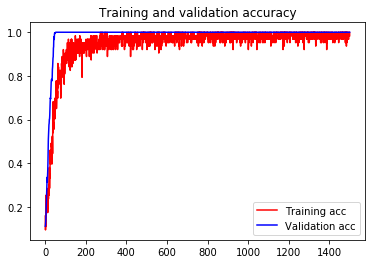

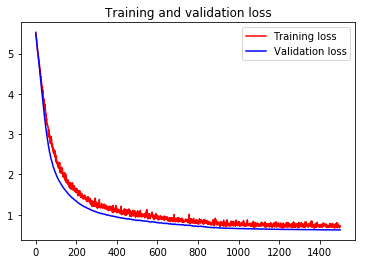

1.0


NameError: name 'load_model' is not defined

In [6]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_ng = Sequential()
neu_ng.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_ng.add(layers.Dropout(0.3))
neu_ng.add(layers.Dense(len(set(train_labels)), activation='softmax'))

neu_ng.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_ng.summary()
history = neu_ng.fit(X_scaled_train_data_ngrams, y_train,
                    validation_data=(X_scaled_val_data_ngrams, y_val),
                    epochs=1500,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_ngrams,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)


In [9]:
l_model = load_model('my_model_neu_ngrams.h5')
yhat = l_model.predict(scaled_test_data_ngrams)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_ngrams Test Accuracy: %.3f' % acc)

my_model_neu_ngrams Test Accuracy: 0.895


In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


neu_wo = Sequential()
neu_wo.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu_wo.add(layers.Dropout(0.3))
neu_wo.add(layers.Dense(len(set(train_labels)), activation='softmax'))


neu_wo.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
neu_wo.summary()
history = neu_wo.fit(X_scaled_train_data_words, y_train,
                    validation_data=(X_scaled_val_data_words, y_val),
                    epochs=2000,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu_words,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu_words.h5')
yhat = l_model.predict( scaled_test_data_words)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu_words Test Accuracy: %.3f' % acc)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                243968    
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 585       
Total para

Epoch 53/2000
63/63 [==============================] - 0s 2ms/step - loss: 3.1184 - acc: 0.7460 - val_loss: 2.8135 - val_acc: 1.0000
Epoch 54/2000
63/63 [==============================] - 0s 2ms/step - loss: 3.0925 - acc: 0.7460 - val_loss: 2.7737 - val_acc: 1.0000
Epoch 55/2000
63/63 [==============================] - 0s 2ms/step - loss: 2.9835 - acc: 0.7619 - val_loss: 2.7321 - val_acc: 1.0000
Epoch 56/2000
63/63 [==============================] - 0s 2ms/step - loss: 2.9371 - acc: 0.7778 - val_loss: 2.6913 - val_acc: 1.0000
Epoch 57/2000
63/63 [==============================] - 0s 2ms/step - loss: 2.9697 - acc: 0.7619 - val_loss: 2.6533 - val_acc: 1.0000
Epoch 58/2000
63/63 [==============================] - 0s 2ms/step - loss: 2.9131 - acc: 0.7778 - val_loss: 2.6162 - val_acc: 1.0000
Epoch 59/2000
63/63 [==============================] - 0s 2ms/step - loss: 2.8940 - acc: 0.7778 - val_loss: 2.5781 - val_acc: 1.0000
Epoch 60/2000
63/63 [==============================] - 0s 2ms/step - 

63/63 [==============================] - 0s 2ms/step - loss: 1.8378 - acc: 0.8571 - val_loss: 1.5484 - val_acc: 1.0000
Epoch 115/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.8363 - acc: 0.9365 - val_loss: 1.5400 - val_acc: 1.0000
Epoch 116/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.8129 - acc: 0.9524 - val_loss: 1.5314 - val_acc: 1.0000
Epoch 117/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.8292 - acc: 0.8889 - val_loss: 1.5242 - val_acc: 1.0000
Epoch 118/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.9064 - acc: 0.8889 - val_loss: 1.5162 - val_acc: 1.0000
Epoch 119/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.9420 - acc: 0.8254 - val_loss: 1.5091 - val_acc: 1.0000
Epoch 120/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.7785 - acc: 0.9683 - val_loss: 1.5028 - val_acc: 1.0000
Epoch 121/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.5460 - acc: 0.9524 - val_loss: 1.2551 - val_acc: 1.0000
Epoch 176/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.4340 - acc: 1.0000 - val_loss: 1.2507 - val_acc: 1.0000
Epoch 177/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.4282 - acc: 0.9524 - val_loss: 1.2456 - val_acc: 1.0000
Epoch 178/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.5808 - acc: 0.9365 - val_loss: 1.2421 - val_acc: 1.0000
Epoch 179/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.4811 - acc: 0.9524 - val_loss: 1.2405 - val_acc: 1.0000
Epoch 180/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.6595 - acc: 0.8413 - val_loss: 1.2418 - val_acc: 1.0000
Epoch 181/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.5225 - acc: 0.9524 - val_loss: 1.2437 - val_acc: 1.0000
Epoch 182/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.3871 - acc: 1.0000 - val_loss: 1.1262 - val_acc: 1.0000
Epoch 237/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3143 - acc: 0.9683 - val_loss: 1.1235 - val_acc: 1.0000
Epoch 238/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3324 - acc: 0.9841 - val_loss: 1.1197 - val_acc: 1.0000
Epoch 239/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3643 - acc: 0.9524 - val_loss: 1.1163 - val_acc: 1.0000
Epoch 240/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3044 - acc: 0.9683 - val_loss: 1.1147 - val_acc: 1.0000
Epoch 241/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3819 - acc: 0.9683 - val_loss: 1.1137 - val_acc: 1.0000
Epoch 242/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.3926 - acc: 0.9524 - val_loss: 1.1149 - val_acc: 1.0000
Epoch 243/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.3166 - acc: 0.9206 - val_loss: 1.0395 - val_acc: 1.0000
Epoch 298/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.2089 - acc: 0.9841 - val_loss: 1.0368 - val_acc: 1.0000
Epoch 299/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1503 - acc: 1.0000 - val_loss: 1.0326 - val_acc: 1.0000
Epoch 300/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.2088 - acc: 0.9683 - val_loss: 1.0306 - val_acc: 1.0000
Epoch 301/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.2785 - acc: 0.9048 - val_loss: 1.0319 - val_acc: 1.0000
Epoch 302/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.2959 - acc: 0.9524 - val_loss: 1.0353 - val_acc: 1.0000
Epoch 303/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1897 - acc: 1.0000 - val_loss: 1.0352 - val_acc: 1.0000
Epoch 304/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.0788 - acc: 0.9841 - val_loss: 0.9714 - val_acc: 1.0000
Epoch 359/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1395 - acc: 0.9524 - val_loss: 0.9688 - val_acc: 1.0000
Epoch 360/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0718 - acc: 1.0000 - val_loss: 0.9652 - val_acc: 1.0000
Epoch 361/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.2242 - acc: 0.9683 - val_loss: 0.9673 - val_acc: 1.0000
Epoch 362/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1136 - acc: 1.0000 - val_loss: 0.9669 - val_acc: 1.0000
Epoch 363/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1945 - acc: 0.9365 - val_loss: 0.9666 - val_acc: 1.0000
Epoch 364/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1086 - acc: 0.9524 - val_loss: 0.9700 - val_acc: 1.0000
Epoch 365/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.0405 - acc: 0.9841 - val_loss: 0.9217 - val_acc: 1.0000
Epoch 420/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0862 - acc: 0.9683 - val_loss: 0.9240 - val_acc: 1.0000
Epoch 421/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.1975 - acc: 0.9048 - val_loss: 0.9308 - val_acc: 1.0000
Epoch 422/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0448 - acc: 0.9683 - val_loss: 0.9302 - val_acc: 1.0000
Epoch 423/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9948 - acc: 1.0000 - val_loss: 0.9261 - val_acc: 1.0000
Epoch 424/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0720 - acc: 0.9841 - val_loss: 0.9201 - val_acc: 1.0000
Epoch 425/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0255 - acc: 1.0000 - val_loss: 0.9166 - val_acc: 1.0000
Epoch 426/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.0578 - acc: 0.9841 - val_loss: 0.8813 - val_acc: 1.0000
Epoch 481/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0287 - acc: 0.9683 - val_loss: 0.8858 - val_acc: 1.0000
Epoch 482/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9946 - acc: 0.9841 - val_loss: 0.8879 - val_acc: 1.0000
Epoch 483/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0432 - acc: 0.9524 - val_loss: 0.8867 - val_acc: 1.0000
Epoch 484/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0055 - acc: 0.9841 - val_loss: 0.8854 - val_acc: 1.0000
Epoch 485/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9950 - acc: 0.9841 - val_loss: 0.8824 - val_acc: 1.0000
Epoch 486/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9876 - acc: 1.0000 - val_loss: 0.8790 - val_acc: 1.0000
Epoch 487/2000
63/63 [==============================] - 0s 2ms/step - loss: 1

63/63 [==============================] - 0s 2ms/step - loss: 1.0326 - acc: 0.9365 - val_loss: 0.8373 - val_acc: 1.0000
Epoch 541/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9659 - acc: 0.9841 - val_loss: 0.8381 - val_acc: 1.0000
Epoch 542/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9756 - acc: 1.0000 - val_loss: 0.8381 - val_acc: 1.0000
Epoch 543/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0093 - acc: 0.9683 - val_loss: 0.8383 - val_acc: 1.0000
Epoch 544/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9673 - acc: 0.9841 - val_loss: 0.8378 - val_acc: 1.0000
Epoch 545/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9386 - acc: 0.9683 - val_loss: 0.8354 - val_acc: 1.0000
Epoch 546/2000
63/63 [==============================] - 0s 2ms/step - loss: 1.0143 - acc: 0.9683 - val_loss: 0.8347 - val_acc: 1.0000
Epoch 547/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.9763 - acc: 0.9524 - val_loss: 0.8169 - val_acc: 1.0000
Epoch 602/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9134 - acc: 1.0000 - val_loss: 0.8157 - val_acc: 1.0000
Epoch 603/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9153 - acc: 1.0000 - val_loss: 0.8129 - val_acc: 1.0000
Epoch 604/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8987 - acc: 1.0000 - val_loss: 0.8106 - val_acc: 1.0000
Epoch 605/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9330 - acc: 1.0000 - val_loss: 0.8104 - val_acc: 1.0000
Epoch 606/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9107 - acc: 0.9841 - val_loss: 0.8096 - val_acc: 1.0000
Epoch 607/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9086 - acc: 1.0000 - val_loss: 0.8081 - val_acc: 1.0000
Epoch 608/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.8975 - acc: 0.9841 - val_loss: 0.7919 - val_acc: 1.0000
Epoch 662/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9058 - acc: 0.9841 - val_loss: 0.7913 - val_acc: 1.0000
Epoch 663/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8922 - acc: 1.0000 - val_loss: 0.7909 - val_acc: 1.0000
Epoch 664/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8457 - acc: 1.0000 - val_loss: 0.7899 - val_acc: 1.0000
Epoch 665/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9387 - acc: 0.9841 - val_loss: 0.7884 - val_acc: 1.0000
Epoch 666/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9095 - acc: 0.9683 - val_loss: 0.7883 - val_acc: 1.0000
Epoch 667/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8964 - acc: 1.0000 - val_loss: 0.7883 - val_acc: 1.0000
Epoch 668/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.8842 - acc: 0.9841 - val_loss: 0.7791 - val_acc: 1.0000
Epoch 723/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8469 - acc: 1.0000 - val_loss: 0.7784 - val_acc: 1.0000
Epoch 724/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8617 - acc: 1.0000 - val_loss: 0.7770 - val_acc: 1.0000
Epoch 725/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8897 - acc: 1.0000 - val_loss: 0.7768 - val_acc: 1.0000
Epoch 726/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8952 - acc: 0.9841 - val_loss: 0.7771 - val_acc: 1.0000
Epoch 727/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8827 - acc: 1.0000 - val_loss: 0.7770 - val_acc: 1.0000
Epoch 728/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8694 - acc: 1.0000 - val_loss: 0.7761 - val_acc: 1.0000
Epoch 729/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.8397 - acc: 0.9841 - val_loss: 0.7681 - val_acc: 1.0000
Epoch 784/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9573 - acc: 0.9683 - val_loss: 0.7689 - val_acc: 1.0000
Epoch 785/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8532 - acc: 1.0000 - val_loss: 0.7693 - val_acc: 1.0000
Epoch 786/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8540 - acc: 0.9841 - val_loss: 0.7687 - val_acc: 1.0000
Epoch 787/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8723 - acc: 0.9841 - val_loss: 0.7682 - val_acc: 1.0000
Epoch 788/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8611 - acc: 1.0000 - val_loss: 0.7679 - val_acc: 1.0000
Epoch 789/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8597 - acc: 0.9683 - val_loss: 0.7671 - val_acc: 1.0000
Epoch 790/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.9410 - acc: 0.9524 - val_loss: 0.7608 - val_acc: 1.0000
Epoch 845/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8707 - acc: 0.9683 - val_loss: 0.7611 - val_acc: 1.0000
Epoch 846/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8920 - acc: 0.9841 - val_loss: 0.7604 - val_acc: 1.0000
Epoch 847/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8935 - acc: 0.9841 - val_loss: 0.7609 - val_acc: 1.0000
Epoch 848/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8341 - acc: 1.0000 - val_loss: 0.7606 - val_acc: 1.0000
Epoch 849/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8733 - acc: 1.0000 - val_loss: 0.7599 - val_acc: 1.0000
Epoch 850/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8756 - acc: 0.9683 - val_loss: 0.7592 - val_acc: 1.0000
Epoch 851/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.8849 - acc: 0.9841 - val_loss: 0.7542 - val_acc: 1.0000
Epoch 905/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8386 - acc: 0.9841 - val_loss: 0.7533 - val_acc: 1.0000
Epoch 906/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8891 - acc: 0.9841 - val_loss: 0.7526 - val_acc: 1.0000
Epoch 907/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8767 - acc: 0.9841 - val_loss: 0.7524 - val_acc: 1.0000
Epoch 908/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8212 - acc: 1.0000 - val_loss: 0.7519 - val_acc: 1.0000
Epoch 909/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8743 - acc: 1.0000 - val_loss: 0.7513 - val_acc: 1.0000
Epoch 910/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9341 - acc: 0.9524 - val_loss: 0.7508 - val_acc: 1.0000
Epoch 911/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.8631 - acc: 0.9683 - val_loss: 0.7420 - val_acc: 1.0000
Epoch 966/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9313 - acc: 0.9365 - val_loss: 0.7422 - val_acc: 1.0000
Epoch 967/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9139 - acc: 0.9841 - val_loss: 0.7427 - val_acc: 1.0000
Epoch 968/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8273 - acc: 1.0000 - val_loss: 0.7428 - val_acc: 1.0000
Epoch 969/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9038 - acc: 0.9841 - val_loss: 0.7426 - val_acc: 1.0000
Epoch 970/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8717 - acc: 0.9841 - val_loss: 0.7426 - val_acc: 1.0000
Epoch 971/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8314 - acc: 0.9841 - val_loss: 0.7423 - val_acc: 1.0000
Epoch 972/2000
63/63 [==============================] - 0s 2ms/step - loss: 0

63/63 [==============================] - 0s 2ms/step - loss: 0.9025 - acc: 0.9683 - val_loss: 0.7374 - val_acc: 1.0000
Epoch 1026/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8152 - acc: 0.9841 - val_loss: 0.7373 - val_acc: 1.0000
Epoch 1027/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8100 - acc: 1.0000 - val_loss: 0.7369 - val_acc: 1.0000
Epoch 1028/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8134 - acc: 0.9841 - val_loss: 0.7366 - val_acc: 1.0000
Epoch 1029/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8280 - acc: 1.0000 - val_loss: 0.7364 - val_acc: 1.0000
Epoch 1030/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8517 - acc: 0.9841 - val_loss: 0.7362 - val_acc: 1.0000
Epoch 1031/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8543 - acc: 0.9683 - val_loss: 0.7361 - val_acc: 1.0000
Epoch 1032/2000
63/63 [==============================] - 0s 2ms/step - 

Epoch 1086/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8323 - acc: 0.9683 - val_loss: 0.7330 - val_acc: 1.0000
Epoch 1087/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8439 - acc: 1.0000 - val_loss: 0.7330 - val_acc: 1.0000
Epoch 1088/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.7956 - acc: 1.0000 - val_loss: 0.7328 - val_acc: 1.0000
Epoch 1089/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8477 - acc: 0.9841 - val_loss: 0.7325 - val_acc: 1.0000
Epoch 1090/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8369 - acc: 0.9841 - val_loss: 0.7325 - val_acc: 1.0000
Epoch 1091/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.7953 - acc: 1.0000 - val_loss: 0.7324 - val_acc: 1.0000
Epoch 1092/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8733 - acc: 0.9841 - val_loss: 0.7322 - val_acc: 1.0000
Epoch 1093/2000
63/63 [==============================] 

Epoch 1146/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8469 - acc: 0.9841 - val_loss: 0.7299 - val_acc: 1.0000
Epoch 1147/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8302 - acc: 1.0000 - val_loss: 0.7299 - val_acc: 1.0000
Epoch 1148/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8296 - acc: 0.9524 - val_loss: 0.7299 - val_acc: 1.0000
Epoch 1149/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8782 - acc: 0.9683 - val_loss: 0.7298 - val_acc: 1.0000
Epoch 1150/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8513 - acc: 0.9841 - val_loss: 0.7299 - val_acc: 1.0000
Epoch 1151/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8006 - acc: 1.0000 - val_loss: 0.7298 - val_acc: 1.0000
Epoch 1152/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.7987 - acc: 1.0000 - val_loss: 0.7298 - val_acc: 1.0000
Epoch 1153/2000
63/63 [==============================] 

63/63 [==============================] - 0s 2ms/step - loss: 0.8594 - acc: 0.9683 - val_loss: 0.7285 - val_acc: 1.0000
Epoch 1207/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8998 - acc: 0.9683 - val_loss: 0.7285 - val_acc: 1.0000
Epoch 1208/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8437 - acc: 0.9841 - val_loss: 0.7286 - val_acc: 1.0000
Epoch 1209/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8432 - acc: 0.9683 - val_loss: 0.7286 - val_acc: 1.0000
Epoch 1210/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8076 - acc: 1.0000 - val_loss: 0.7286 - val_acc: 1.0000
Epoch 1211/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8284 - acc: 0.9841 - val_loss: 0.7284 - val_acc: 1.0000
Epoch 1212/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8250 - acc: 1.0000 - val_loss: 0.7283 - val_acc: 1.0000
Epoch 1213/2000
63/63 [==============================] - 0s 2ms/step - 

63/63 [==============================] - 0s 2ms/step - loss: 0.7942 - acc: 1.0000 - val_loss: 0.7268 - val_acc: 1.0000
Epoch 1267/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8008 - acc: 0.9683 - val_loss: 0.7267 - val_acc: 1.0000
Epoch 1268/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8313 - acc: 1.0000 - val_loss: 0.7267 - val_acc: 1.0000
Epoch 1269/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.7982 - acc: 1.0000 - val_loss: 0.7266 - val_acc: 1.0000
Epoch 1270/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8662 - acc: 0.9841 - val_loss: 0.7266 - val_acc: 1.0000
Epoch 1271/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8730 - acc: 0.9683 - val_loss: 0.7266 - val_acc: 1.0000
Epoch 1272/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8680 - acc: 0.9683 - val_loss: 0.7267 - val_acc: 1.0000
Epoch 1273/2000
63/63 [==============================] - 0s 2ms/step - 

Epoch 1327/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9199 - acc: 0.9365 - val_loss: 0.7260 - val_acc: 1.0000
Epoch 1328/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8411 - acc: 0.9683 - val_loss: 0.7261 - val_acc: 1.0000
Epoch 1329/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8548 - acc: 0.9841 - val_loss: 0.7261 - val_acc: 1.0000
Epoch 1330/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8465 - acc: 1.0000 - val_loss: 0.7261 - val_acc: 1.0000
Epoch 1331/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8152 - acc: 0.9841 - val_loss: 0.7261 - val_acc: 1.0000
Epoch 1332/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8216 - acc: 1.0000 - val_loss: 0.7260 - val_acc: 1.0000
Epoch 1333/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.9260 - acc: 0.9683 - val_loss: 0.7261 - val_acc: 1.0000
Epoch 1334/2000
63/63 [==============================] 

63/63 [==============================] - 0s 2ms/step - loss: 0.8599 - acc: 0.9683 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1388/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8616 - acc: 0.9841 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1389/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8660 - acc: 0.9683 - val_loss: 0.7254 - val_acc: 1.0000
Epoch 1390/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8142 - acc: 1.0000 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1391/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8094 - acc: 0.9841 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1392/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.8189 - acc: 1.0000 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1393/2000
63/63 [==============================] - 0s 2ms/step - loss: 0.7802 - acc: 1.0000 - val_loss: 0.7253 - val_acc: 1.0000
Epoch 1394/2000
63/63 [==============================] - 0s 2ms/step - 

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model, load_model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)


# conv_input_tensor = Input(shape=(maxlen,) , name='convnets')

# conv_1d_s3_model = Sequential()
# conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s3_model.add(layers.Dropout(0.2))
# conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_0 = conv_1d_s3_model(conv_input_tensor)


# conv_1d_s1_model = Sequential()
# conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_s1_model.add(layers.Dropout(0.2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_1 = conv_1d_s1_model(conv_input_tensor)

# conv_1d_complex_model = Sequential()
# conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
# conv_1d_complex_model.add(layers.Dropout(0.2))
# conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.GlobalMaxPooling1D())

# conv_output_tensor_2 = conv_1d_complex_model(conv_input_tensor)



concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1,
#                                    conv_output_tensor_0,
#                                    conv_output_tensor_1,
#                                    conv_output_tensor_2,
                                  ], axis=-1)

concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor,
#                conv_input_tensor
              ], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
print(X_scaled_train_data_ngrams.shape, X_scaled_train_data_words.shape, y_train.shape) 
history = model.fit([X_scaled_train_data_ngrams, X_scaled_train_data_words, 
#                      X_train
                    ], y_train,
                    validation_data=([X_scaled_val_data_ngrams, X_scaled_val_data_words,
#                                       X_val
                                     ], y_val),
                    epochs=2000,
                    batch_size=class_size,
                    callbacks=callbacks_list_neu,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))
l_model = load_model('my_model_neu.h5')
yhat = l_model.predict([scaled_test_data_ngrams, scaled_test_data_words])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_neu Test Accuracy: %.3f' % acc)

In [ ]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

convnet_input_tensor = Input(shape=(maxlen,) , name='convnet_words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.3))
conv_1d_s3_model.add(layers.SeparableConv1D(64, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
conv_output_tensor_0 = conv_1d_s3_model(convnet_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.3))
conv_1d_s1_model.add(layers.SeparableConv1D(64, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
conv_output_tensor_1 = conv_1d_s1_model(convnet_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.3))
conv_1d_complex_model.add(layers.SeparableConv1D(64, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
conv_output_tensor_2 = conv_1d_complex_model(convnet_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

concatenated = layers.concatenate([conv_output_tensor_0,
                                   conv_output_tensor_1,
                                   conv_output_tensor_2,
#                                    ,added
                                  ], axis=-1)
concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(convnet_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=class_size,
                    callbacks=callbacks_list_convnet,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
l_model = load_model('my_model_convnet.h5')
yhat = l_model.predict(X_test)
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('my_model_convnet Test Accuracy: %.3f' % acc)

In [ ]:
print(max(val_acc))

In [ ]:
from keras.models import load_model
from keras.utils import to_categorical
from numpy import dstack
from keras.utils import plot_model
from keras.layers.merge import concatenate

# load models from file
def load_all_models(model_names_list):
    all_models = list()
    for model_name in model_names_list:
        # define filename for this ensemble
#         filename = 'models/model_' + str(i + 1) + '.h5'
        filename = model_name + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models


# define stacked model from multiple member input models
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer.name = 'ensemble_' + str(i + 1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
#     print(ensemble_visible)
#     ensemble_visible = [[ngram_input_tensor, word_input_tensor], convnet_input_tensor]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
#     ensemble_outputs = [concatenated, answer]
    merge = concatenate(ensemble_outputs)
    hidden = layers.Dense(128, activation='relu')(merge)
    hidden = layers.Dropout(0.3)(hidden)
    output = layers.Dense(len(set(train_labels)), activation='softmax')(hidden)
    model = Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
#     plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=3e-4), metrics=['accuracy'])
    return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy, valX, valy):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # encode output data
#     inputy_enc = to_categorical(inputy)
    # fit model
    model.fit(inputX, inputy, validation_data=(valX, valy), batch_size=class_size,
              callbacks=callbacks_list_stacked, epochs=500, verbose=1)
    
# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
    # prepare input data
#     X = [inputX for _ in range(len(model.input))]
    # make prediction
    return model.predict(inputX, verbose=0)

print('done!')

In [ ]:

members = load_all_models(['my_model_neu_ngrams', 'my_model_neu_words', 'my_model_convnet'])
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, [X_scaled_train_data_ngrams, X_scaled_train_data_words, X_train], y_train, [X_scaled_val_data_ngrams, X_scaled_val_data_words, X_val], y_val)
final_model = load_model('my_model_neu_stacked.h5')
# make predictions and evaluate
yhat = predict_stacked_model(stacked_model, [scaled_test_data_ngrams, scaled_test_data_words, test_data])
yhat = argmax(yhat, axis=1)
acc = accuracy_score(test_labels, yhat)
print('Stacked Test Accuracy: %.3f' % acc)